<a href="https://colab.research.google.com/github/rhdtka21/Intro-To-AI/blob/master/newPJTgpu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
from fastai.vision import *
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import cv2

path = 'samples'
fileNames = os.listdir(path)
print(os.listdir(path)[:10])

['yxd7m.png', 'e667x.png', '5x5nx.png', 'egxmp.png', 'fgb36.png', '5mnpd.png', '6pfy4.png', 'nw5b2.png', 'nxcmn.png', 'c3572.png']


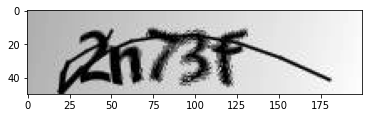

In [3]:
image = cv2.imread('samples/2n73f.png', cv2.IMREAD_GRAYSCALE)

plt.imshow(image, cmap='gray')

In [0]:
def label_from_filename(path):
    label = [char for char in path.name[:-4]]
    return label

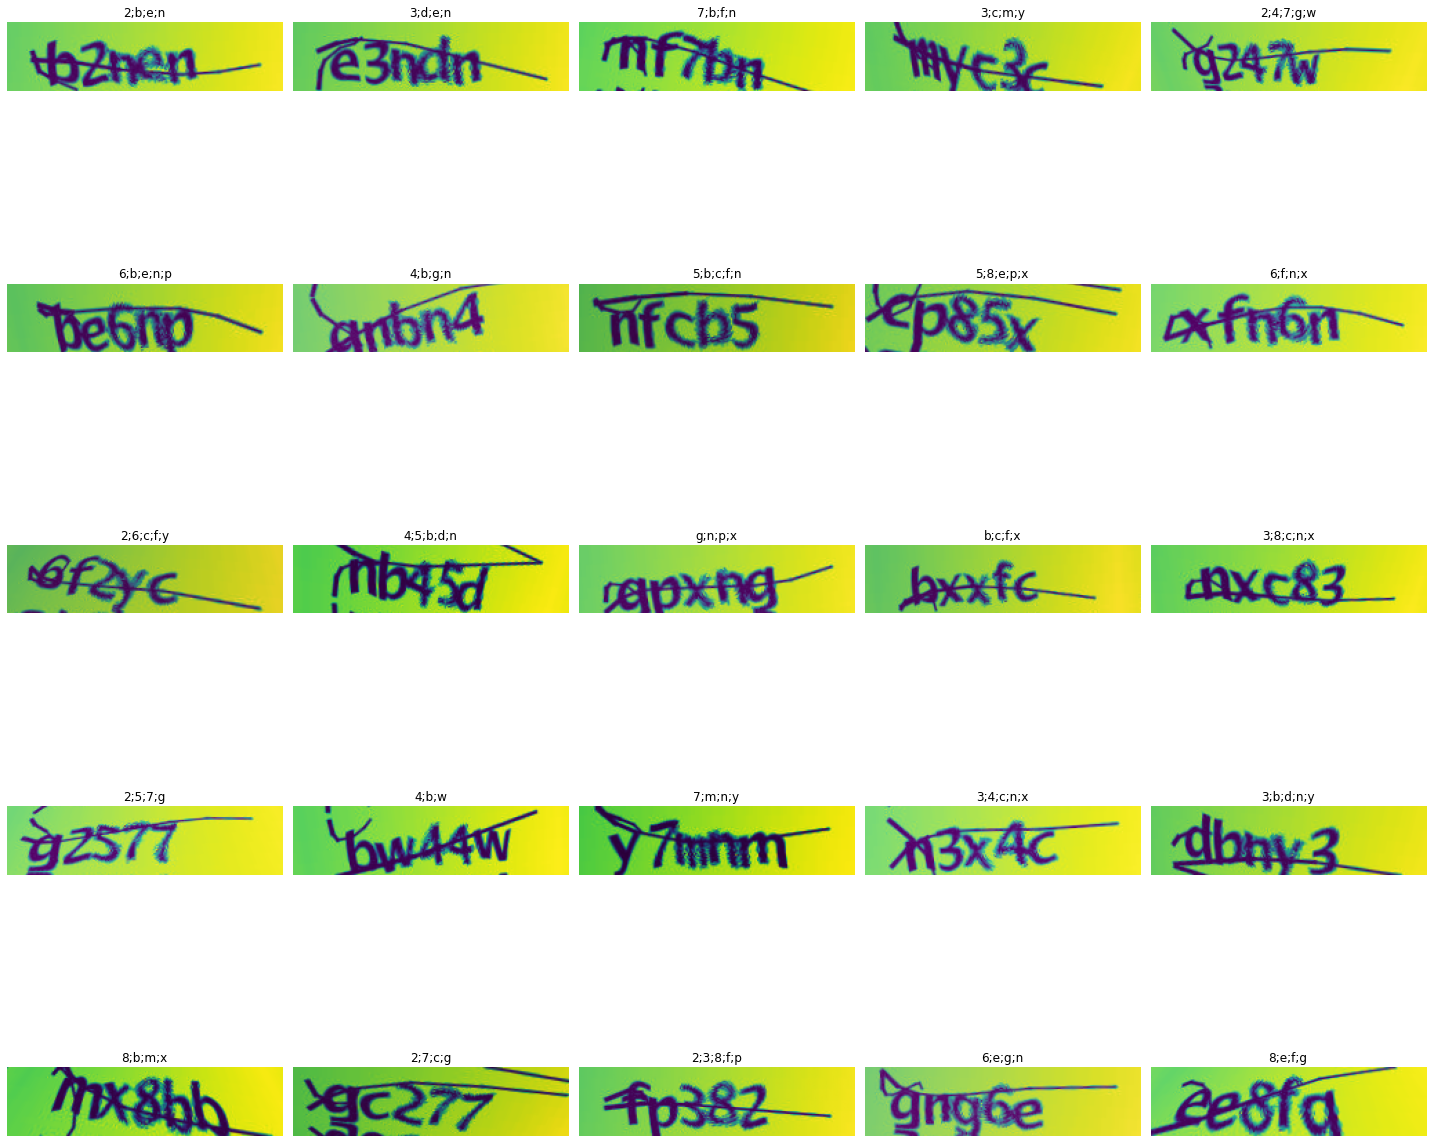

In [0]:
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)                       # Split the data between the training and the validation set
        .label_from_func(label_from_filename)         # Label the inputs
        .transform(get_transforms(do_flip=False))     # Data Augmentation (글씨이므로 Flip은 하지 않습니다.)
                                                      # Rotation, Zoom, 등
        .databunch()
        .normalize()
       )
data.show_batch(5)

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


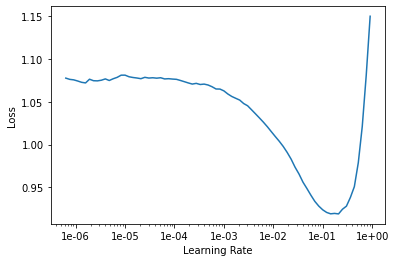

In [7]:
learn = cnn_learner(data, models.resnet18, model_dir='/tmp', metrics=acc_02)
lr_find(learn)
learn.recorder.plot()

In [8]:
lr = 5e-2
# lr = 1e-1

learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.938368,1.492813,0.597105,00:02
1,0.825490,2.466815,0.644474,00:02
2,0.755554,0.882043,0.636316,00:02
3,0.677702,0.547688,0.677105,00:02
4,0.620405,0.468177,0.674210,00:02


In [0]:
import copy
losses = copy.deepcopy(learn.recorder.losses)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


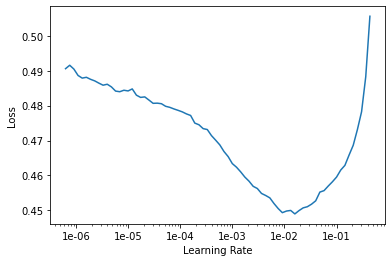

In [10]:
learn.unfreeze()
lr_find(learn)
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(15, slice(1e-3, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,time
0,0.473193,0.522654,0.682632,00:02
1,0.449569,0.656571,0.709474,00:02
2,0.425219,0.534661,0.728421,00:02
3,0.399310,0.723754,0.745000,00:02
4,0.366409,0.542617,0.781579,00:02
5,0.331088,0.500931,0.796842,00:02
6,0.296366,0.298550,0.872105,00:02
7,0.262212,0.212637,0.893947,00:02
8,0.229706,0.138426,0.936579,00:02
9,0.198928,0.110265,0.948158,00:02


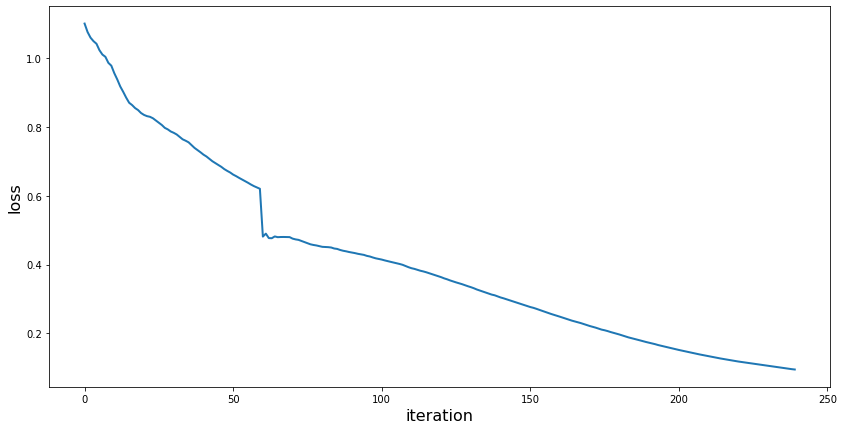

In [12]:
losses += learn.recorder.losses

fig, ax = plt.subplots(figsize=(14,7))
ax.plot(losses, linewidth=2)
ax.set_ylabel('loss', fontsize=16)
ax.set_xlabel('iteration', fontsize=16)
plt.show()

---------------------------------------------------------------------------

In [0]:
def plot_lr(learn):
    lr_find(learn)
    learn.recorder.plot()

def char_from_path(path, position):
    return path.name[position]
   

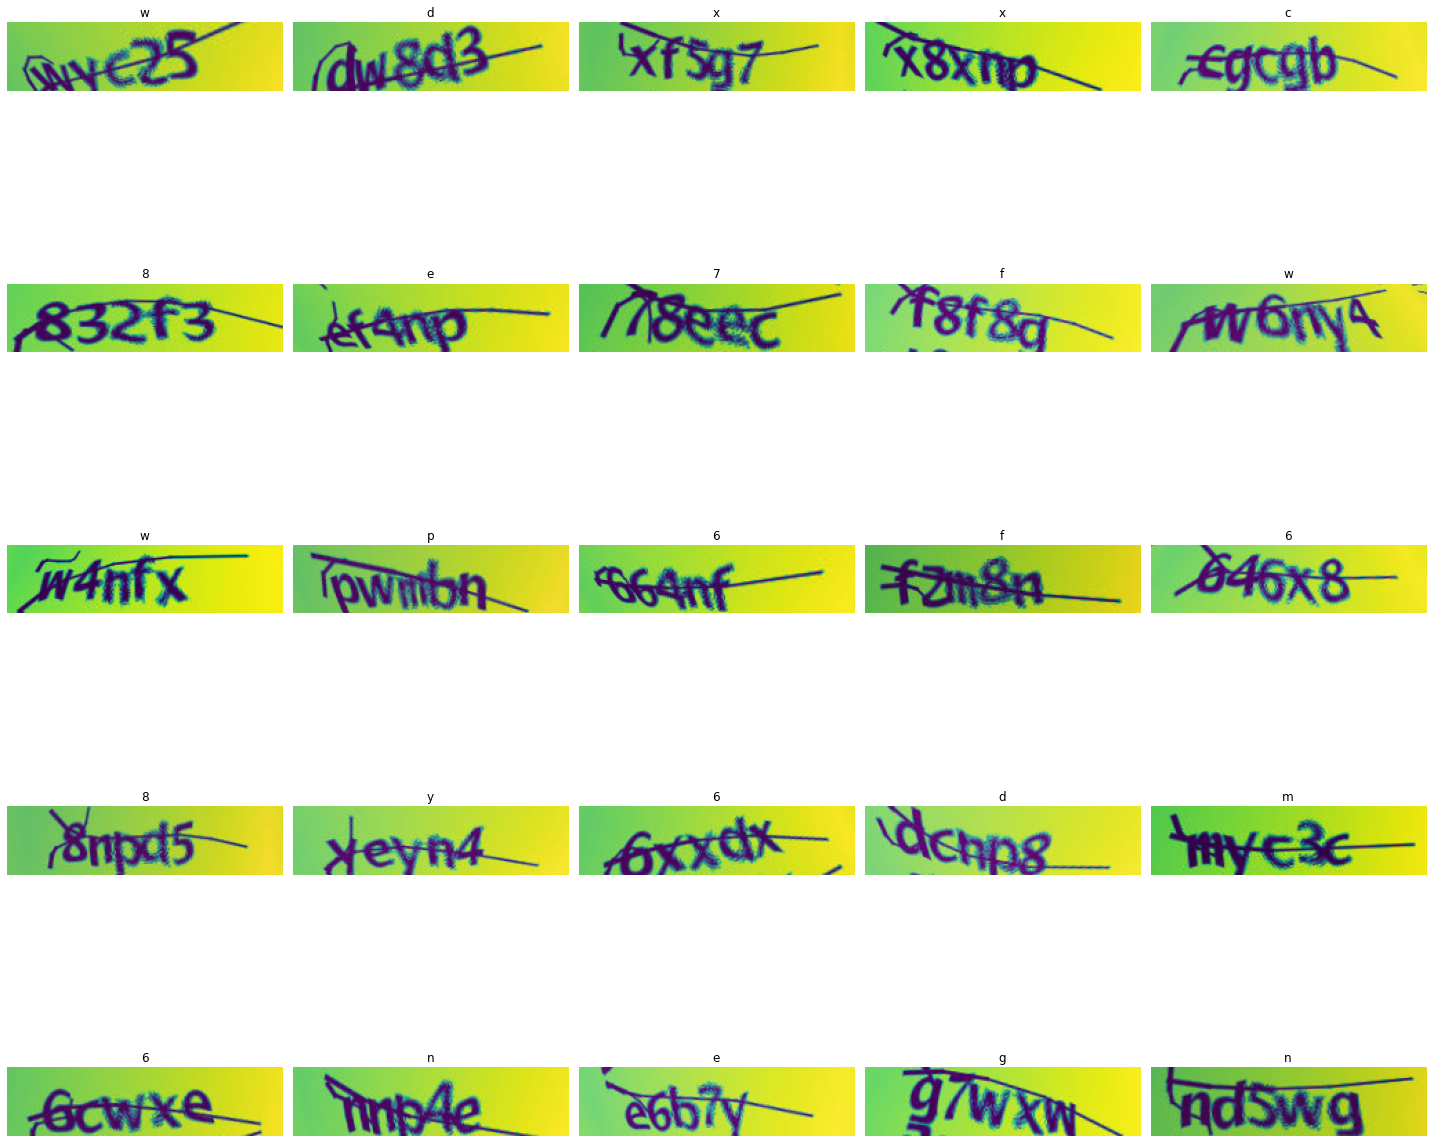

In [14]:
data = (ImageList.from_folder(path)
        .split_by_rand_pct(0.2)
        .label_from_func(partial(char_from_path, position=0))
        .transform(get_transforms(do_flip=False))
        .databunch()
       .normalize())

data.show_batch(5)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/checkpoints/resnet34-333f7ec4.pth


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


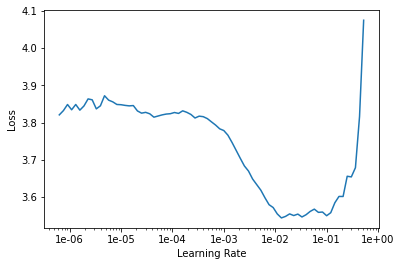

In [15]:
learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp', ps=0.)

plot_lr(learn)

In [16]:
lr = 5e-2
learn.fit_one_cycle(5, lr)

epoch,train_loss,valid_loss,accuracy,time
0,4.444261,24.011076,0.095000,00:02
1,4.335407,18.032921,0.070000,00:02
2,3.872680,6.932615,0.135000,00:02
3,3.292301,4.125597,0.155000,00:02
4,2.824719,2.288522,0.250000,00:02


In [0]:
learn.save('pretrained')

learn.load('pretrained')
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


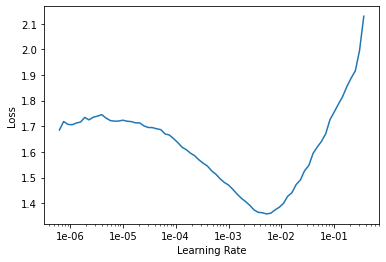

In [18]:
plot_lr(learn)

In [19]:
learn.fit_one_cycle(15, slice(5e-4, lr/5))

epoch,train_loss,valid_loss,accuracy,time
0,1.628115,2.120267,0.400000,00:02
1,1.397298,5.143653,0.200000,00:02
2,1.214859,2.424706,0.430000,00:02
3,1.063499,6.291358,0.210000,00:02
4,0.926209,2.052469,0.565000,00:02
5,0.814731,2.514166,0.575000,00:02
6,0.712629,1.135875,0.610000,00:02
7,0.625704,0.367971,0.860000,00:02
8,0.531201,0.291628,0.900000,00:02
9,0.442041,0.168236,0.935000,00:02


In [20]:
interp = ClassificationInterpretation.from_learner(learn)

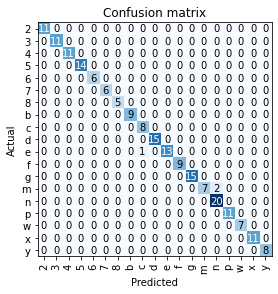

In [21]:
interp.plot_confusion_matrix()

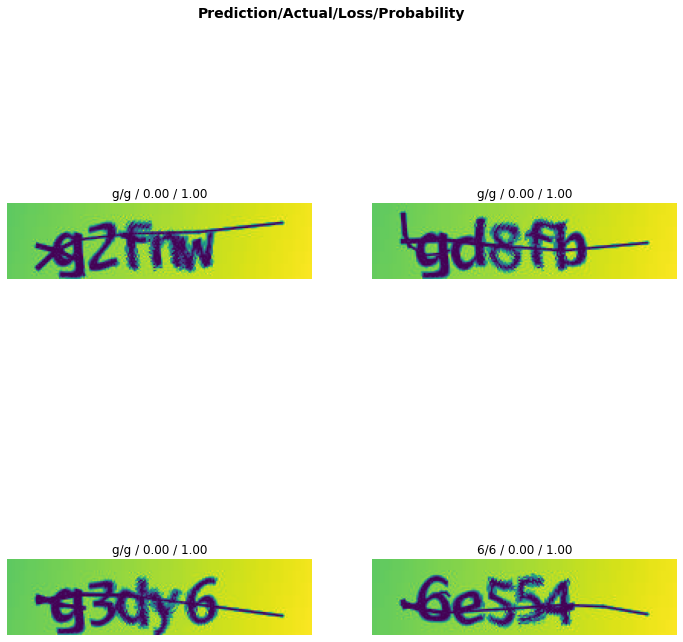

In [29]:
interp.plot_top_losses(4, heatmap_thresh=5, largest=False)

In [0]:
def data_from_position(position):
    data = (ImageList.from_folder(path) #Where to find the data? -> in path and its subfolders
        .split_by_rand_pct(0.2)              #How to split in train/valid? -> use the folders
        .label_from_func(partial(char_from_path, position=position))            #How to label? -> depending on the folder of the filenames
        .transform(get_transforms(do_flip=False))       #Data augmentation? -> use tfms with a size of 64
        .databunch())                   #Finally? -> use the defaults for conversion to ImageDataBunch
    return data

In [31]:
learners = []
for i in range(5):
    data = data_from_position(i)
    
    learn = cnn_learner(data, models.resnet34, metrics=accuracy, model_dir='/tmp', ps=0.)
    
    lr = 5e-2
    learn.fit_one_cycle(5, lr)
    
    learn.unfreeze()
    learn.fit_one_cycle(15, slice(5e-4, lr/5))
    
    learners.append(learn)

epoch,train_loss,valid_loss,accuracy,time
0,4.591629,19.678703,0.050000,00:02
1,4.581939,43.907261,0.035000,00:02
2,4.118757,10.936404,0.055000,00:02
3,3.573957,2.880790,0.220000,00:02
4,3.130605,2.043594,0.315000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.990154,3.594212,0.200000,00:02
1,1.668710,2.848861,0.350000,00:02
2,1.455481,5.270850,0.275000,00:02
3,1.299575,4.682376,0.290000,00:02
4,1.111388,2.507850,0.540000,00:02
5,0.966819,1.084226,0.685000,00:02
6,0.828382,1.670532,0.625000,00:02
7,0.702686,0.327304,0.860000,00:02
8,0.600791,0.393321,0.845000,00:02
9,0.508672,0.114682,0.960000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.296238,25.826832,0.040000,00:02
1,4.234946,34.004868,0.045000,00:02
2,3.920045,7.783356,0.040000,00:02
3,3.395955,3.521749,0.115000,00:02
4,2.975136,2.371383,0.260000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.810361,2.223586,0.345000,00:02
1,1.575914,2.928852,0.240000,00:02
2,1.379656,2.852704,0.385000,00:02
3,1.211361,5.205089,0.395000,00:02
4,1.095912,5.318789,0.235000,00:02
5,0.970845,1.042415,0.725000,00:02
6,0.828843,0.653300,0.805000,00:02
7,0.697553,3.336087,0.375000,00:02
8,0.578060,0.505986,0.845000,00:02
9,0.478161,0.345503,0.915000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.484977,24.626474,0.050000,00:02
1,4.668093,9.378051,0.060000,00:02
2,4.242442,16.188871,0.055000,00:02
3,3.764785,5.327529,0.085000,00:02
4,3.397832,2.973665,0.135000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,2.441593,3.360596,0.210000,00:02
1,2.236896,2.898439,0.300000,00:02
2,1.957550,3.366598,0.220000,00:02
3,1.700108,3.507023,0.260000,00:02
4,1.524359,5.394001,0.315000,00:02
5,1.285715,1.241557,0.595000,00:03
6,1.080703,1.705687,0.545000,00:02
7,0.901180,0.788506,0.740000,00:02
8,0.736952,0.353727,0.885000,00:02
9,0.600733,0.325679,0.920000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,4.233335,13.796112,0.050000,00:02
1,4.181601,11.404693,0.020000,00:02
2,3.635850,6.815260,0.115000,00:02
3,2.979386,2.590406,0.320000,00:02
4,2.468083,1.508130,0.520000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,1.238674,1.707560,0.460000,00:02
1,1.049790,4.873734,0.185000,00:02
2,0.907878,4.193887,0.305000,00:02
3,0.777922,2.731314,0.435000,00:02
4,0.709027,1.725475,0.575000,00:02
5,0.631115,1.043580,0.695000,00:02
6,0.546827,1.173409,0.755000,00:02
7,0.487202,2.143574,0.550000,00:02
8,0.402581,0.839407,0.750000,00:02
9,0.331392,0.278259,0.900000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,3.632015,19.915031,0.075000,00:02
1,3.076987,24.339043,0.090000,00:02
2,2.472607,16.435562,0.110000,00:02
3,1.902032,2.643722,0.435000,00:02
4,1.469373,0.495095,0.800000,00:02


epoch,train_loss,valid_loss,accuracy,time
0,0.568279,1.548321,0.695000,00:02
1,0.533857,16.535439,0.160000,00:02
2,0.540296,10.151034,0.230000,00:02
3,0.483739,5.654750,0.390000,00:02
4,0.472024,1.733847,0.700000,00:02
5,0.432773,2.258191,0.595000,00:02
6,0.382037,0.720571,0.795000,00:02
7,0.327368,0.149880,0.955000,00:02
8,0.275759,0.275427,0.900000,00:02
9,0.230184,0.035052,0.990000,00:02


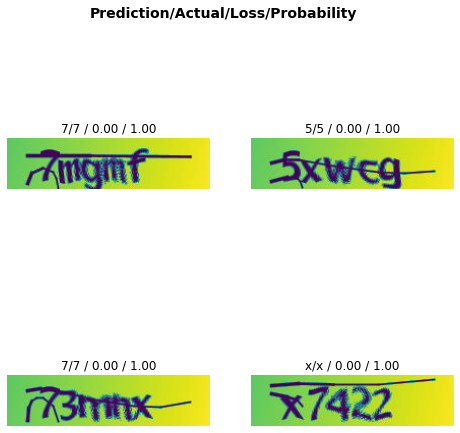

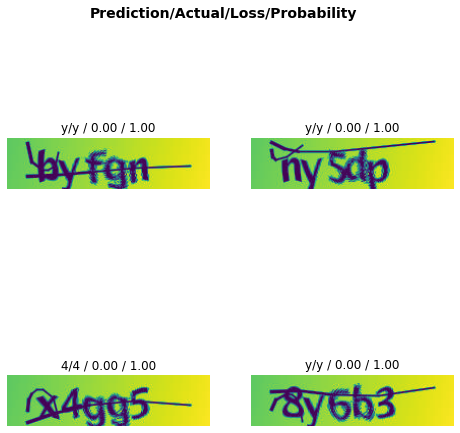

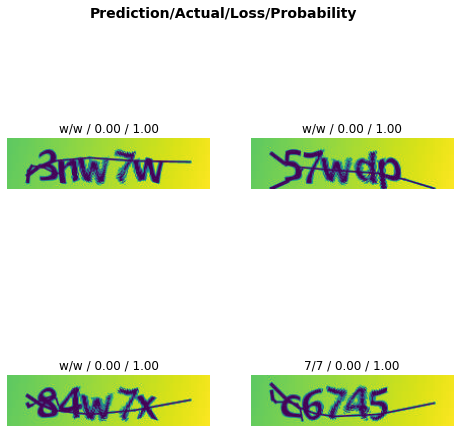

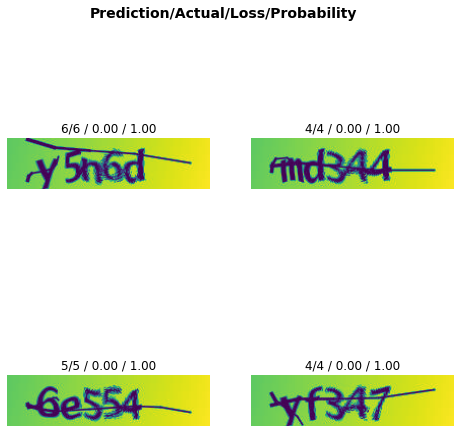

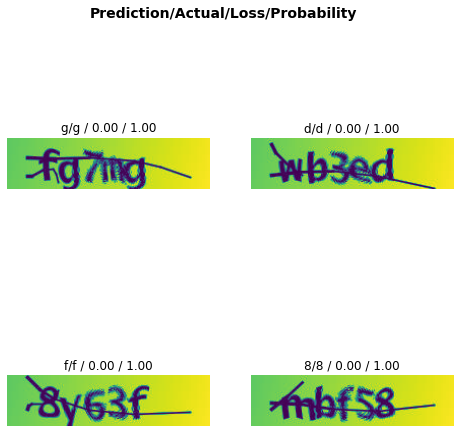

In [39]:
figures = []
for learner in learners:
    figures.append(learner.interpret().plot_top_losses(4, heatmap_thresh=14, figsize=(8,8), largest=False, return_fig=True ))

In [0]:
for e,f in enumerate(figures):
    f.suptitle('')
    for a in f.axes: a.set_title(f'Position: {e+1}')
    f.savefig(f'{e}_heatmap.png', bbox_inches='tight')

In [0]:
def predict_captcha(img, learners):
    return ''.join([str(learner.predict(img)[0]) for learner in learners])

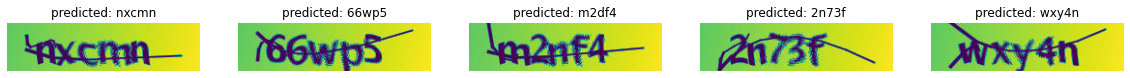

In [42]:
fig, ax = plt.subplots(ncols=5, figsize=(20,10))
for a, (img, lbl) in zip(ax.flatten(), learners[0].data.valid_ds):
    show_image(img, a)
    a.set_title(f'predicted: {predict_captcha(img, learners)}')
plt.show()

In [0]:
img_paths = learners[1].data.valid_ds.items
count = 0
correct = 0

for img_path in img_paths:
    lbl = img_path.name[:-4]
    img = open_image(img_path)
    predicted = predict_captcha(img, learners)
    if lbl==predicted: correct +=1
    count += 1
print(correct, count, correct/count)

189 200 0.945
